In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import cm
from matplotlib.lines import Line2D

import time
from numpy.random import default_rng

import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import pandas as pd

import astropy.cosmology
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import masks
import maps

# Parameter setting

Plot formatting

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

Saving

In [3]:
plot_dir = '../plots/2023-10-08_figures'
save = True

In [4]:
quants = {}

In [5]:
fn_quants = '../data/quantities_comparison.txt'
save = True

Names

In [6]:
name_gpurer = "\emph{{Gaia}} DR3 Quasars `Purer' Sample"
abbrv_gpurer = "\emph{{Gaia}} DR3 `Purer'"

name_sqall = "SDSS DR16Q Quasars"
abbrv_sqall = "SDSS DR16Q Quasars"

Plotting variables

In [7]:
cmap_map = 'plasma'

Functions

In [8]:
def get_map(ras, decs):
    map_nqso, _ = maps.get_map(NSIDE, ras, decs, null_val=0)
    map_ndens = map_nqso/area_per_pixel
    map_ndens_masked = hp.ma(map_ndens)
    map_ndens_masked.mask = map_ndens==0
    return map_ndens_masked

In [9]:
# via eqn 2, https://www.aanda.org/articles/aa/full_html/2015/02/aa23280-13/aa23280-13.html
def r_sdss_to_G_gaia(r):
    return 0.97 * r + 0.39

Map settings

In [10]:
NSIDE = 64
area_per_pixel = hp.nside2pixarea(NSIDE, degrees=True)
print(f"Area per pixel: {area_per_pixel:.3f} deg")

Area per pixel: 0.839 deg


Other prelims

In [11]:
G_hi = 20.5
G_lo = 20.0

# Figures

## Gaia purer

In [12]:
fn_gall = '../data/gaia_candidates_plus.fits.gz'
tab_gall = utils.load_table(fn_gall)
print(len(tab_gall))

6649162


In [13]:
fn_gpurer_ids = '../data/gaia_purer_sourceids.fits'
tab_gpurer_ids = utils.load_table(fn_gpurer_ids)
tab_gpurer = join(tab_gall, tab_gpurer_ids, keys='source_id', join_type='inner', metadata_conflicts='silent')
print(len(tab_gpurer))

1942825


In [14]:
idx_Glim_gpurer = tab_gpurer['phot_g_mean_mag'] < G_hi
print(np.sum(idx_Glim_gpurer))

1493729


In [15]:
idx_has_zgaia = np.isfinite(tab_gpurer['redshift_qsoc'])
print(np.sum(idx_has_zgaia))

1729625


In [16]:
tab_gpurer_good = tab_gpurer[idx_has_zgaia]
tab_gpurer_Glim = tab_gpurer[idx_has_zgaia & idx_Glim_gpurer]

In [17]:
map_gpurer = get_map(tab_gpurer_Glim['ra'], 
                     tab_gpurer_Glim['dec'])

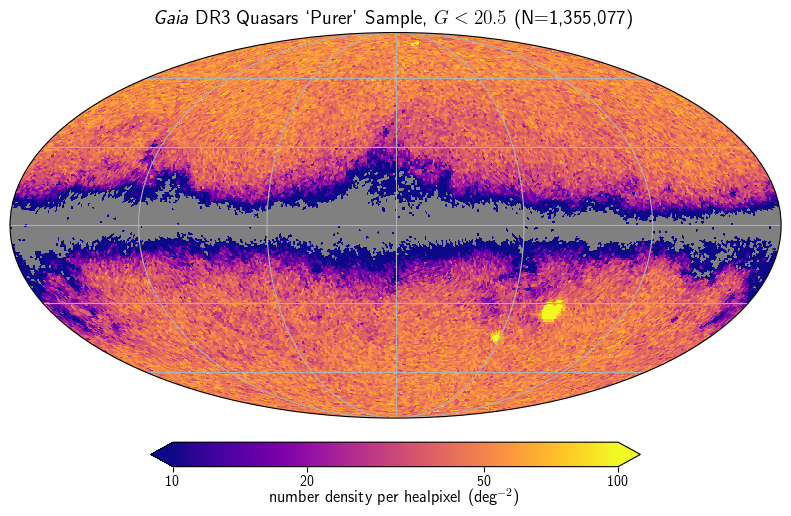

In [18]:
projview(map_gpurer, title=rf"{name_gpurer}, $G<{G_hi}$ (N={len(tab_gpurer_Glim):,})",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=10, max=100, norm='log', graticule=True,
            cbar_ticks=[10, 20, 50, 100])
fn = f'{plot_dir}/gpurer_Ghi_2d.png'
if save:
    plt.savefig(fn)

## WISE+PS

NOTE:
The newer version published in August 2022 (https://zenodo.org/records/6998864) is different - it doesn't load in properly with the converter because of a null value, and the numbers don't look right. It only has 2475775 rows, but the updated abstract has more than that even for the reliable ones: https://academic.oup.com/mnras/article/516/2/2662/6677420?login=true

For now i am continuing to use the June 2022 version (https://zenodo.org/record/6998864#.ZDM78OzMJhE), which matches the numbers in original arXiv abstract: https://arxiv.org/pdf/2206.01440.pdf

In [19]:
# downloaded from zenodo: https://zenodo.org/record/6998864#.ZDM78OzMJhE
fn_wiseps = '/scratch/ksf293/gaia-quasars-lss/data/PS1_WISE_QSO_photoz_catalog.csv'
#tab_wiseps = Table.read(fn_wiseps, converters={'EXT': bool}) #needed this before, not now for some reason
tab_wiseps = Table.read(fn_wiseps) 
print(len(tab_wiseps))

4849634


In [20]:
idx_reliable = tab_wiseps['EXT']=='False'
print(np.sum(idx_reliable))

2879298


Great, matches abstract numbers! 

"We estimated reliable photometric redshifts of 2,879,298 quasars which overlap with the training set in
feature space"

In [21]:
# PS1 r magnitude is very similar to SDSS r: https://outerspace.stsci.edu/display/PANSTARRS/PS1+Filter+properties
idx_Glim_wiseps = r_sdss_to_G_gaia(tab_wiseps['rFPSFMag']) < 20.4
print(np.sum(idx_Glim_wiseps))

1361982


In [22]:
tab_wiseps_reliable = tab_wiseps[idx_reliable]
tab_wiseps_reliable_Glim = tab_wiseps[idx_reliable & idx_Glim_wiseps]

In [23]:
map_wiseps_reliable_Glim = get_map(tab_wiseps_reliable_Glim['raMean'], tab_wiseps_reliable_Glim['decMean'])

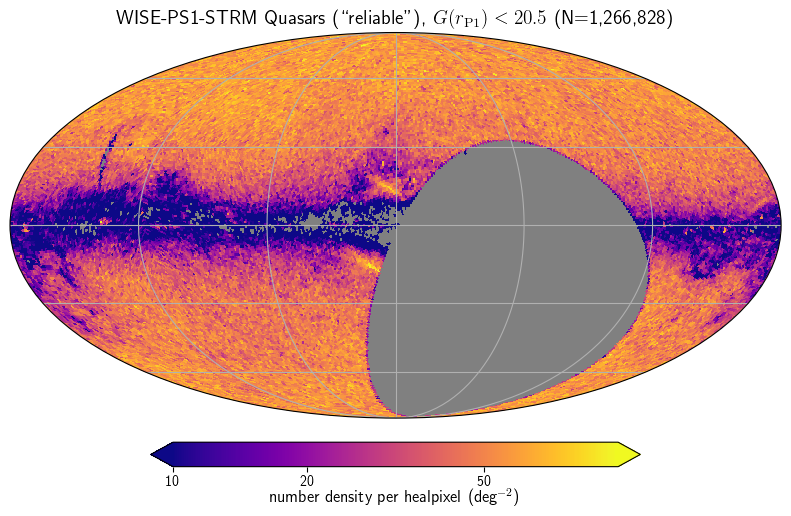

In [24]:
projview(map_wiseps_reliable_Glim, 
         title=rf"WISE-PS1-STRM Quasars (``reliable''), $G(r_\mathrm{{P1}}) < {G_hi}$ (N={len(tab_wiseps[idx_Glim_wiseps & idx_reliable]):,})",
         unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
         min=10, max=100, norm='log', graticule=True,
         cbar_ticks=[10, 20, 50])
fn = f'{plot_dir}/wiseps_Ghi_2d.png'
if save:
    plt.savefig(fn)

# Milliquas

In [25]:
fn_mill = '../data/milliquas.fits.zip'
tab_mill = utils.load_table(fn_mill)
print(len(tab_mill))

1453164


In [26]:
print(tab_mill.columns)

<TableColumns names=('RA','DEC','NAME','TYPE','RMAG','BMAG','COMMENT','R','B','Z','CITE','ZCITE','RXPCT','QPCT','XNAME','RNAME','LOBE1','LOBE2')>


RMAG data is heterogeneous - from diff catalogs / filters. So we just use the SDSS conversion and hope it's close enough.

In [27]:
values, counts = np.unique(tab_mill['CITE'], return_counts=True)

ind = np.argpartition(-counts, kth=10)[:10]
for i in ind:
    print(values[i], counts[i])  # prints the 10 most frequent elements
    
print('total:',np.sum(counts))

DR16Q  717418
WISEA  31676
MQ     459068
DR16   43263
2QZ    27534
GAIA3  23730
NBCKv3 26784
XDQSO  21214
PGC    20303
2SLAQ  10367
total: 1453164


In [28]:
idx_Glim_mill = r_sdss_to_G_gaia(tab_mill['RMAG']) < G_hi
print(np.sum(idx_Glim_mill), len(idx_Glim_mill), np.sum(idx_Glim_mill)/len(idx_Glim_mill))
map_ndens_mill = get_map(tab_mill['RA'][idx_Glim_mill], tab_mill['DEC'][idx_Glim_mill])
N = len(tab_mill[idx_Glim_mill])

912050 1453164 0.6276304670360675


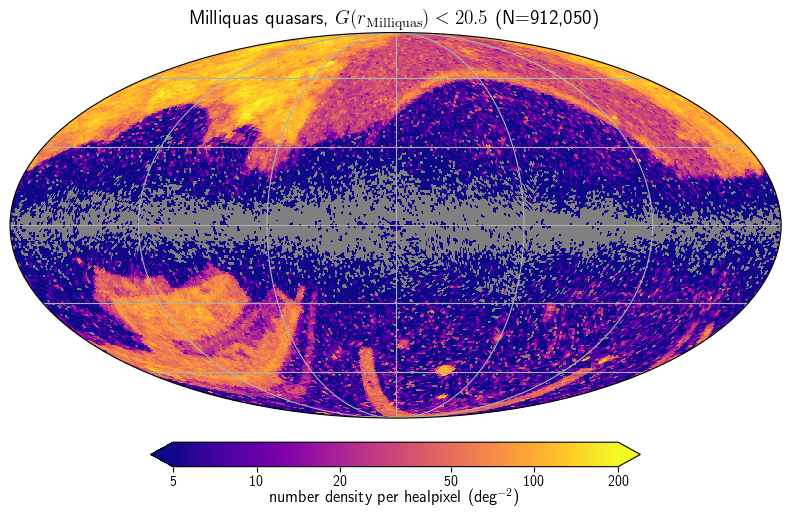

In [29]:
projview(map_ndens_mill, title=rf"Milliquas quasars, $G(r_\mathrm{{Milliquas}})<{G_hi}$ (N={N:,})",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=5, max=200, norm='log', graticule=True,
            cbar_ticks=[5, 10, 20, 50, 100, 200])

fn = f'{plot_dir}/milliquas_Ghi_2d.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

## eBOSS

In [30]:
fn_eboss = '../data/eBOSS_QSO_full_ALLdata-vDR16_changecolname.fits'
tab_eboss = Table.read(fn_eboss)
print(f"Number of eboss quasars: {len(tab_eboss)}")

Number of eboss quasars: 655521


In [31]:
# ugriz, so r is 2
r_mag_eboss = tab_eboss['MODELMAG'][:,2]

In [32]:
i_imatch = (tab_eboss['IMATCH']==1) | (tab_eboss['IMATCH']==2)
print(np.sum(i_imatch))

i_comp = (tab_eboss['COMP_BOSS']>0.5)
i_sect = (tab_eboss['sector_SSR']>0.5)
print(np.sum(i_comp), np.sum(i_sect))
print(np.sum(i_comp & i_sect))

i_clust = i_imatch & i_comp & i_sect
print(np.sum(i_clust))
tab_eboss_clust = tab_eboss[i_clust]
                           
i_zwarning0 = tab_eboss['ZWARNING']==0
tab_eboss_good = tab_eboss[i_clust & i_zwarning0]
print(len(tab_eboss_good))

454452
538994 567466
538628
452531
409341


In [33]:
i_Glim_eboss = r_sdss_to_G_gaia(r_mag_eboss) < G_hi
print(np.sum(i_Glim_eboss))

284273


In [34]:
tab_eboss_Glim = tab_eboss[i_clust & i_zwarning0 & i_Glim_eboss]

In [35]:
map_eboss = get_map(tab_eboss_Glim['RA'], 
                    tab_eboss_Glim['DEC'])

In [36]:
N_eboss = len(tab_eboss_Glim)

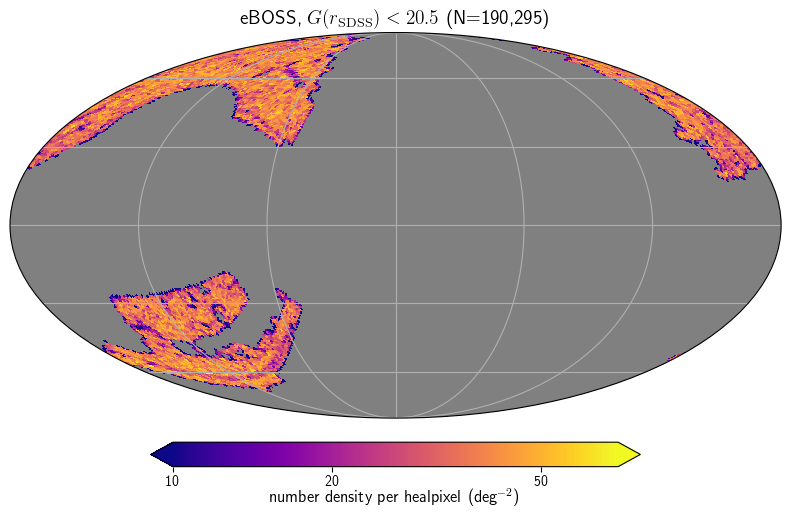

In [37]:
projview(map_eboss, title=rf"eBOSS, $G(r_\mathrm{{SDSS}})<{G_hi}$ (N={N_eboss:,})",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=10, max=70, norm='log', graticule=True,
            cbar_ticks=[10, 20, 50])
fn = f'{plot_dir}/eboss_Ghi_2d.png'
if save:
    plt.savefig(fn)

## SDSS DR16Q

In [38]:
tab_sqall = utils.load_table(f'../data/quasars_sdss_xgaiaall_xunwiseall_good.fits')
print(f"Number of all SDSS quasars: {len(tab_sqall)}")

Number of all SDSS quasars: 638083


In [39]:
tab_sqall.columns

<TableColumns names=('ra','dec','source_id','ra_sdss','dec_sdss','objid','z_sdss','thing_id','u_mag_sdss','g_mag_sdss','r_mag_sdss','i_mag_sdss','z_mag_sdss','u_mag_err_sdss','g_mag_err_sdss','r_mag_err_sdss','i_mag_err_sdss','z_mag_err_sdss','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','phot_bp_n_obs','phot_rp_n_obs','dec_unwise','mag_w1_vg','mag_w2_vg','ra_unwise','unwise_objid','dist_arcsec')>

In [40]:
idx_Glim_sdss = r_sdss_to_G_gaia(tab_sqall['r_mag_sdss']) < G_hi
print(np.sum(idx_Glim_sdss))

298442


In [41]:
tab_sqall_Glim = tab_sqall[idx_Glim_sdss]
N_sqall = len(tab_sqall_Glim)

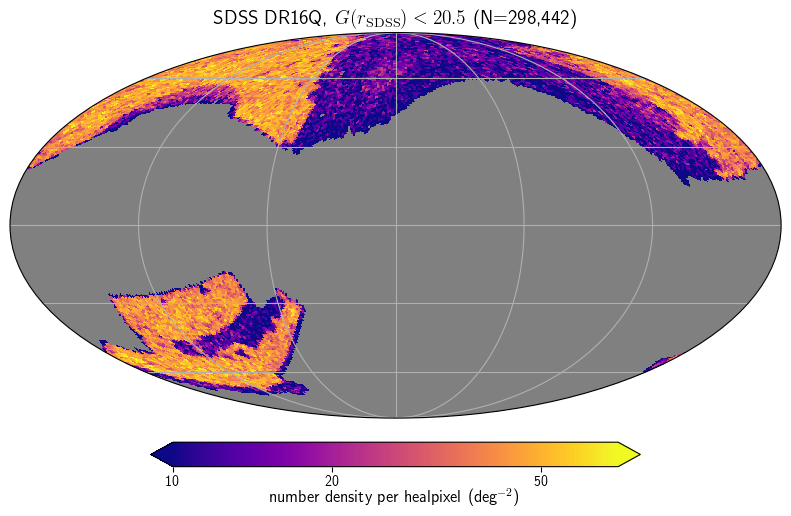

In [42]:
map_sdss = get_map(tab_sqall_Glim['ra_sdss'], tab_sqall_Glim['dec_sdss'])
projview(map_sdss, title=rf"SDSS DR16Q, $G(r_\mathrm{{SDSS}})<{G_hi}$ (N={N_sqall:,})",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=10, max=70, norm='log', graticule=True,
            cbar_ticks=[10, 20, 50])
fn = f'{plot_dir}/sdss_Ghi_2d.png'
if save:
    plt.savefig(fn)

# Catalog quantities

### Numbers

In [43]:
frac_reliable = np.sum(idx_reliable)/len(idx_reliable)
p_reliable = round(100*frac_reliable)
quants['p_reliable_wiseps'] = p_reliable

### Volume calculations

In [44]:
def v_shells_of_z(z_bins, fsky, cosmo):
    
    v_at_z_bins = np.empty(len(z_bins), dtype=u.Quantity)
    for i in range(len(z_bins)):
        v = cosmo.comoving_volume(z_bins[i])
        v_at_z_bins[i] = v.to(u.Gpc**3)
    v_at_z_bins *= fsky
    v_shells = v_at_z_bins[1:] - v_at_z_bins[:-1] 
    
    # ALT METHOD, same answer
#     z_bins_avg = 0.5*(z_bins[:-1] + z_bins[1:])
#     dvol = cosmo.differential_comoving_volume(z_bins_avg)  # THIS GETS  VOL PER UNIT REDSHIFT PER UNIT SOLID ANGLE
#     dz = z_bins[1:] - z_bins[:-1]
#     dvol = (4.*np.pi)*u.sr * dz * dvol # THIS GETS THE TOTAL VOLUME WITHIN EACH BIN OF REDSHIFT
#     v_shells = dvol.to(u.Gpc**3) * fsky
    
    return np.array(v_shells)

In [45]:
def ndens_of_z(z_arr, z_bins, fsky, cosmo):
    
    v_shells = v_shells_of_z(z_bins, fsky, cosmo)
    ndens = []
    for i in range(len(z_bins)-1):
        N_inbin = np.sum((z_arr >= z_bins[i]) & (z_arr < z_bins[i+1]))
        ndens_inbin = N_inbin/v_shells[i]
        ndens.append(ndens_inbin)
        
    # ALT METHOD, same answer
#     N_zhist = np.histogram(z_arr,bins=z_bins) 
#     ndens = N_zhist[0]/v_shells
    return ndens

In [46]:
# eqn 1.7.32 of https://arxiv.org/pdf/1606.00180.pdf
def volume_effective_Gpcperh(z_arr, z_bins, cosmo, fsky, P0):
    
    ndens_at_z_bins = ndens_of_z(z_arr, z_bins, fsky, cosmo)
    ndens_at_z_bins = np.array(ndens_at_z_bins, dtype=u.Quantity)

    nPs = np.array([n*P0 for n in ndens_at_z_bins])
    prefacs = (nPs /(1 + nPs))**2
    v_shells = v_shells_of_z(z_bins, fsky, cosmo)    
    v_Gpc = np.sum(prefacs*v_shells)

    v_Gpc = v_Gpc.to(u.Gpc**3) # this should be just in Gpc
    v_Gpcperh = v_Gpc * cosmo.h**3 # (Gpc) -> (Gpc/h)^3, mult by h^3 
    print(f"Sky fraction is {fsky:.3f}")
    print(f"Effective volume is {v_Gpc:.3f} = {v_Gpcperh.value:.3f} (Gpc/h)^3")
    return v_Gpcperh.value

In [47]:
from astropy.cosmology import Planck18
cosmo = Planck18
area_allsky = 41252.96125#*(u.deg**2)
P0 = 4e4 * u.Mpc**3 / cosmo.h**3 

In [48]:
fn_dustmap = f'../data/maps/map_dust_NSIDE{NSIDE}.npy'
map_dust = maps.get_dust_map(NSIDE=NSIDE, R=3.1, fn_map=fn_dustmap)

Av_hi = 0.5
quants['Avhi'] = Av_hi

Dustmap already exists, loading from ../data/maps/map_dust_NSIDE64.npy


## Load Quaia, combine w sdss data for reference redshifts (and for gpurer)

In [49]:
fn_gcathi = f'../data/catalog_G{G_hi}.fits'
tab_gcathi = utils.load_table(fn_gcathi)
print(len(tab_gcathi))

1295502


In [50]:
fn_gcatlo = f'../data/catalog_G{G_lo}.fits'
tab_gcatlo = utils.load_table(fn_gcatlo)
print(len(tab_gcatlo))

755850


In [51]:
tab_sq = utils.load_table(f'../data/quasars_sdss_xgaiaall_xunwiseall.csv', format='csv')
tab_sq.rename_column('t1_source_id', 'source_id')
tab_sq.rename_column('t1_z', 'z_sdss')
print(f"Number of SDSS xgaiaall quasars: {len(tab_sq)}")
tab_sq.keep_columns(['source_id', 'z_sdss'])
# remove sq objects with no gaia source_id
tab_sq = tab_sq[~tab_sq['source_id'].mask]

Number of SDSS xgaiaall quasars: 638089


In [52]:
tab_gpurer_good = join(tab_gpurer_good, tab_sq, keys='source_id', join_type='left')
tab_gpurer_Glim = join(tab_gpurer_Glim, tab_sq, keys='source_id', join_type='left')
tab_gcathi = join(tab_gcathi, tab_sq, keys='source_id', join_type='left')
tab_gcatlo = join(tab_gcatlo, tab_sq, keys='source_id', join_type='left')

## Set up comparison tables

In [53]:
tables_Glim = {'eboss_Glim': tab_eboss_Glim,
               'sdss_Glim': tab_sqall_Glim,
               'wiseps_Glim': tab_wiseps_reliable_Glim,
               'gpurer_Glim': tab_gpurer_Glim
                }

tables_nolim = {'eboss': tab_eboss_good,
               'sdss': tab_sqall,
               'gcathi': tab_gcathi,
               'wiseps': tab_wiseps_reliable,
               'gpurer': tab_gpurer_good
                }

tables_all = tables_Glim
tables_all.update(tables_nolim)

zlabels = {'eboss': 'Z',
           'sdss': 'z_sdss',
             'gcathi': 'redshift_spz',
             'gcatlo': 'redshift_spz',
             'wiseps': 'z_pred_mean',
             'gpurer': 'redshift_qsoc'
            }

zspec_labels = {'gcathi': 'z_sdss',
                'gcatlo': 'z_sdss',
             'wiseps': 'spectroz',
             'gpurer': 'z_sdss'
            }

survey_names = {'eboss': 'eBOSS Clustering',
                'sdss': 'SDSS DR16Q',
                 'gcathi': 'Quaia',
                 'gcatlo': 'Quaia ($G<20.0$)',
                 'wiseps': 'WISE-PS1',
                 'gpurer': '\emph{Gaia} Purer',
                 'eboss_Glim': '\hspace{1.5em}$G_\mathrm{eff}<20.5$',
                 'sdss_Glim': '\hspace{1.5em}$G_\mathrm{eff}<20.5$',
                 'wiseps_Glim': '\hspace{1.5em}$G_\mathrm{eff}<20.5$',
                 'gpurer_Glim': '\hspace{1.5em}$G<20.5$',
                }

radec_names = {'eboss': ['RA', 'DEC'],
               'sdss': ['ra', 'dec'],
                 'gcathi': ['ra', 'dec'],
                 'gcatlo': ['ra', 'dec'],
                 'wiseps': ['raMean', 'decMean'],
                 'gpurer': ['ra', 'dec']
                }

In [54]:
tnames = ['gcathi', 'gpurer', 'gpurer_Glim', 'wiseps', 'wiseps_Glim', 
          'sdss', 'sdss_Glim', 'eboss', 'eboss_Glim']
tables_nodust = {}
for name_full in tnames:
    table = tables_all[name_full]
    name = name_full if 'Glim' not in name_full else name_full.split('_Glim')[0]
    
    ra_name, dec_name = radec_names[name]
    pixel_indices = hp.ang2pix(NSIDE, table[ra_name], table[dec_name], lonlat=True)
    NPIX = hp.nside2npix(NSIDE)
    counts_by_pixel = np.bincount(pixel_indices, minlength=NPIX)
    i_keep = (map_dust[pixel_indices] < Av_hi) & (counts_by_pixel[pixel_indices]>0)
    i_pix_keep = (map_dust < Av_hi) & (counts_by_pixel>0)
    print(name_full, np.sum(i_keep), len(i_keep), f'{np.sum(i_keep)/len(i_keep):.3}')
    tables_nodust[name_full] = table[i_keep]

gcathi 1234715 1295503 0.953
gpurer 1647311 1729626 0.952
gpurer_Glim 1286788 1355078 0.95
wiseps 2386121 2879298 0.829
wiseps_Glim 1130925 1266828 0.893


/ext3/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/ext3/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/healpy/pixelfunc.py:482: RuntimeWarning: invalid value encountered in _ang2pix_ring
  return pixlib._ang2pix_ring(nside, theta, phi)


sdss 637371 638083 0.999
sdss_Glim 297940 298442 0.998
eboss 409286 409341 1.0
eboss_Glim 190263 190295 1.0


In [55]:
N_arr, area_arr, nbar_arr, fsky_arr, veff_arr, vspan_arr, zmed_arr = [], [], [], [], [], [], []
fskys = {}
for name_full in tnames:
    table = tables_nodust[name_full]
    name = name_full if 'Glim' not in name_full else name_full.split('_Glim')[0]
    
    ra_name, dec_name = radec_names[name]
    pixel_indices = hp.ang2pix(NSIDE, table[ra_name], table[dec_name], lonlat=True)
    NPIX = hp.nside2npix(NSIDE)
    counts_by_pixel = np.bincount(pixel_indices, minlength=NPIX)
    i_keep = (map_dust[pixel_indices] < Av_hi) & (counts_by_pixel[pixel_indices]>0)
    i_pix_keep = (map_dust < Av_hi) & (counts_by_pixel>0)
    print(np.sum(i_keep), len(i_keep))
    table = table[i_keep]
    
    N = len(table)
    quants[f'N_{name}'] = rf'{N:,}'
    
    #area = areas[name]
    area = np.sum(i_pix_keep) * area_per_pixel 
    quants[f'area_{name}'] = rf'{area:.2f} deg$^2$'
    fsky = area/area_allsky
    fskys[name] = fsky
    quants[f'fsky_{name}'] = f'{fsky:.2f}'
    
    nbar = len(table)/area
    quants[f'nbar_{name}'] = rf'{nbar:.2f} deg$^{-2}$'

    z_arr = table[zlabels[name]]
    z_min, z_max = np.min(z_arr), np.max(z_arr)
    z_bins = np.arange(0, z_max+0.1, 0.1)

    vol = volume_effective_Gpcperh(z_arr, z_bins, cosmo, fsky, P0)
    vol_fmt = rf'{vol:.2f} $(h^{{-1}}\,Gpc)^3$'
    quants[f'volume_effective_{name}'] = vol_fmt
    
    z_range = [0.8, 2.2]
    vol_span = v_shells_of_z(z_range, fsky, cosmo)[0]
    vol_span = (vol_span.to(u.Gpc**3) * cosmo.h**3).value # (Gpc) -> (Gpc/h)^3, mult by h^3 
    print(vol_span)
    vol_span_fmt = rf'{vol_span:.2f} $(h^{{-1}}\,Gpc)^3$'
    quants[f'volume_spanning_{name}'] = vol_span_fmt
        
    N_arr.append(f'{N:,}')
    area_arr.append(f'{area:.2f}')
    nbar_arr.append(f'{nbar:.2f}')
    fsky_arr.append(f'{fsky:.2f}')
    veff_arr.append(f'{vol:.2f}')
    vspan_arr.append(f'{vol_span:.2f}')
    #zmed_arr.append(f'{zmed:.2f}')
     #     print(quants[f'N_{name}'])
#     print(quants[f'area_{name}'])
#     print(quants[f'nbar_{name}'])
#     print(quants[f'fsky_{name}'])
#     print(quants[f'volume_effective_{name}'])
#     print(quants[f'volume_spanning_{name}'])
#     print(quants[f'zmed_{name}'])
#     print()

1234715 1234715
Sky fraction is 0.734
Effective volume is 22.854 Gpc3 = 7.079 (Gpc/h)^3
143.7849761796034
1647311 1647311
Sky fraction is 0.734
Effective volume is 29.830 Gpc3 = 9.239 (Gpc/h)^3
143.76106051256497
1286788 1286788
Sky fraction is 0.734
Effective volume is 20.972 Gpc3 = 6.496 (Gpc/h)^3
143.76106051256497
2386121 2386121
Sky fraction is 0.557
Effective volume is 67.408 Gpc3 = 20.879 (Gpc/h)^3
109.0793573623216
1130925 1130925
Sky fraction is 0.557
Effective volume is 23.618 Gpc3 = 7.315 (Gpc/h)^3
109.06341358429599
637371 637371
Sky fraction is 0.257
Effective volume is 13.419 Gpc3 = 4.156 (Gpc/h)^3
50.30261967085064
297940 297940
Sky fraction is 0.256
Effective volume is 3.810 Gpc3 = 1.180 (Gpc/h)^3
50.22688672522892
409286 409286
Sky fraction is 0.137
Effective volume is 10.378 Gpc3 = 3.215 (Gpc/h)^3
26.801490861077628
190263 190263
Sky fraction is 0.136
Effective volume is 3.251 Gpc3 = 1.007 (Gpc/h)^3
26.610165524770114


In [56]:
zmed_arr, f01_arr, f001_arr = [], [], []
for name_full in tnames:
    table = tables_nodust[name_full]
    name = name_full if 'Glim' not in name_full else name_full.split('_Glim')[0]
    
    z_arr = table[zlabels[name]]

    zmed = np.median(z_arr)
    zmed_arr.append(f'{zmed:.2f}')
    quants[f'zmed_{name}'] = rf'{zmed:.2f}'
   
    if name in zspec_labels:
        z_spec = table[zspec_labels[name]]
        if name=='wiseps':
            i_has_zspec = table[zspec_labels[name]]!=-999
        else:
            i_has_zspec = ~table[zspec_labels[name]].mask
        z_spec = table[zspec_labels[name]][i_has_zspec]
        z_est = z_arr[i_has_zspec]

        dz = (z_est - z_spec)/(1 + z_spec)
        n_tot = len(dz)

        n_below = np.sum(np.abs(dz) < 0.01)
        f001 = f'{n_below/n_tot:.2f}'
        f001_arr.append(f001)

        n_below = np.sum(np.abs(dz) < 0.1)
        f01 = f'{n_below/n_tot:.2f}'
        f01_arr.append(f01)
        
        quants[f'frac_acc_dzlo_{name}'] = f001
        quants[f'frac_acc_dzmid_{name}'] = f01
        
    else: 
        f001_arr.append('$\sim$1')
        f01_arr.append('$\sim$1')

/ext3/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [57]:
table_table = Table([tnames, N_arr, area_arr, nbar_arr, fsky_arr, veff_arr, vspan_arr, zmed_arr, f001_arr, f01_arr], 
                    names=('tname', 'N', 'area', 'nbar', 'fsky', 'volume_effective', 'volume_spanning', 
                           'zmed','f001','f01'))

In [58]:
column_labels = {'N': r'$N$', 
                'fsky': r'$f_\text{sky}$',
                 'nbar': r'$\bar{n}, \newline \text{deg}^{-2}$',
                'volume_spanning': r'$V_\text{span}, \newline (h^{-1}\,\text{Gpc})^3$',
                'volume_effective': r'$V_\text{eff}, \newline (h^{-1}\,\text{Gpc})^3$', 
                'zmed': r'$z_\text{med}$',
                'survey_name': '',
                'f001': r'$f(|\delta z| <0.01)$',
                'f01': r'$f(|\delta z| <0.1)$'
#                 'f001': r'$f(|\delta z| \newline <0.01)$',
#                 'f01': r'$f(|\delta z| \newline <0.1)$'
                }

In [59]:
#{|l|l|l|p{2.5em}|p{4.5em}|p{4.5em}|l|p{6em}|p{6em}|}
column_widths = {'N': None, 
                'fsky': None,
                'nbar': 2.5,
                'volume_spanning': 4.5,
                'volume_effective': 4.5, 
                'zmed': None,
                'survey_name': None,
                #'f001': 3.5,
                #'f01': 3.5
                'f001': 7,
                'f01': 7
                }

In [60]:
quant_names = ['N', 'fsky', 'nbar', 'volume_spanning', 'volume_effective', 'zmed', 'f001', 'f01']
table_column_names = ['survey_name'] + quant_names

table_contents = '\\begin{tabular}'
width_strs = ['p{'+str(column_widths[tc])+'em}' if column_widths[tc] is not None else 'l' for tc in table_column_names]
table_contents += '{|'+'|'.join(width_strs) + '|}\n'
#table_contents += '{|'+'|'.join(['l' for _ in table_column_names]) + '|}\n'
table_contents += '\hline\n'
table_contents += ' & '.join(column_labels[tc] for tc in table_column_names) + ' \\\\\n'
#table_contents += '\hline\n'
table_contents += '\hhline{|' + '=|'*len(table_column_names) + '}\n'

#tnames_show = ['gcathi', 'gpurer', 'wiseps', 'eboss']
tnames_show = tnames
table_table.add_index('tname')
for tname in tnames_show:
    if 'Glim' not in tname and 'gcathi' not in tname:
        table_contents += '\hline\n'
    #i = table_table.loc[tname]
    #print(i)
    row_vals = [str(table_table.loc[tname][qn]) for qn in quant_names]
    #row_vals = [quants[f'{qn}_{tname}'] for qn in quant_names]
    row_vals = [survey_names[tname]] + row_vals
    if tname=='gcathi':
        row_vals = [f'\\textbf{{{rv}}}' for rv in row_vals]
    row = ' & '.join(row_vals) + ' \\\\\n'
#     if i<len(table_table)-1:
#         row += ' \\\\ \n'
    #print(row,end='') # end makes print not print an additional newline
    table_contents += row

table_contents += '\hline\n'
table_contents += '\end{tabular}'
print(table_contents)    

\begin{tabular}{|l|l|l|p{2.5em}|p{4.5em}|p{4.5em}|l|p{7em}|p{7em}|}
\hline
 & $N$ & $f_\text{sky}$ & $\bar{n}, \newline \text{deg}^{-2}$ & $V_\text{span}, \newline (h^{-1}\,\text{Gpc})^3$ & $V_\text{eff}, \newline (h^{-1}\,\text{Gpc})^3$ & $z_\text{med}$ & $f(|\delta z| <0.01)$ & $f(|\delta z| <0.1)$ \\
\hhline{|=|=|=|=|=|=|=|=|=|}
\textbf{Quaia} & \textbf{1,234,715} & \textbf{0.73} & \textbf{40.78} & \textbf{143.78} & \textbf{7.08} & \textbf{1.48} & \textbf{0.63} & \textbf{0.84} \\
\hline
\emph{Gaia} Purer & 1,647,311 & 0.73 & 54.42 & 143.76 & 9.24 & 1.63 & 0.53 & 0.62 \\
\hspace{1.5em}$G<20.5$ & 1,286,788 & 0.73 & 42.51 & 143.76 & 6.50 & 1.61 & 0.62 & 0.70 \\
\hline
WISE-PS1 & 2,386,121 & 0.56 & 103.89 & 109.08 & 20.88 & 1.38 & 0.11 & 0.71 \\
\hspace{1.5em}$G_\mathrm{eff}<20.5$ & 1,130,925 & 0.56 & 49.25 & 109.06 & 7.32 & 1.41 & 0.12 & 0.76 \\
\hline
SDSS DR16Q & 637,371 & 0.26 & 60.18 & 50.30 & 4.16 & 1.77 & $\sim$1 & $\sim$1 \\
\hspace{1.5em}$G_\mathrm{eff}<20.5$ & 297,940 & 0.26 &

In [61]:
fn_table = '../data/comparison_table.txt'
with open(fn_table, 'w') as f:
    if save:
        f.write(table_contents)
if save:
    print(f"Saved to {fn_table}!")

Saved to ../data/comparison_table.txt!


## GALEX comparison

In [62]:
fn_gaia_galex = '../data/gaia_galex.fits.gz'
print("Loading data")
tab_gaia_galex = utils.load_table(fn_gaia_galex)

Loading data


In [63]:
tab_gcathi_galex = astropy.table.join(tab_gcathi, tab_gaia_galex, keys='source_id', join_type='left', 
                                      metadata_conflicts='silent')

In [64]:
i_has_nuv = np.isfinite(tab_gcathi_galex['nuvmag'])
i_has_fuv = np.isfinite(tab_gcathi_galex['fuvmag'])

In [65]:
frac_nuv = np.sum(i_has_nuv)/len(i_has_nuv)
frac_nuv_fuv = np.sum(i_has_nuv & i_has_fuv)/len(i_has_nuv & i_has_fuv)

p_nuv = round(100*frac_nuv)
p_nuv_fuv = round(100*frac_nuv_fuv)
quants[f'p_nuv_galex'] = p_nuv
quants[f'p_nuv_fuv_galex'] = p_nuv_fuv
print(p_nuv, p_nuv_fuv)

32 16


## Pan-STARRS

In [66]:
fn_gaia_ps = '../data/panstarrs_qsos_xmatch-result.fits.gz'
print("Loading data")
tab_gaia_ps = utils.load_table(fn_gaia_ps)

Loading data


In [67]:
len(tab_gaia_ps)

6649162

In [68]:
tab_gcathi_ps = astropy.table.join(tab_gcathi, tab_gaia_ps, keys='source_id', join_type='left', 
                                      metadata_conflicts='silent')

In [69]:
tab_gcathi_ps.columns

<TableColumns names=('source_id','ra_1','dec_1','l','b','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','phot_g_n_obs','phot_bp_n_obs','phot_rp_n_obs','redshift_qsoc','redshift_qsoc_lower','redshift_qsoc_upper','zscore_qsoc','flags_qsoc','pmra','pmra_error','pmdec','pmdec_error','parallax','parallax_error','ebv','A_v','pm','mag_w1_vg','mag_w2_vg','unwise_objid','rand_ints','g_rp','bp_g','bp_rp','g_w1','w1_w2','redshift_spz_raw','redshift_spz_err','redshift_spz','z_sdss','ra_2','dec_2','obj_id','ra_panstarrs','dec_panstarrs','g_mean_psf_mag','r_mean_psf_mag','i_mean_psf_mag','z_mean_psf_mag','y_mean_psf_mag','quality_flag')>

In [70]:
i_has_ps = np.isfinite(tab_gcathi_ps['g_mean_psf_mag']) & \
           np.isfinite(tab_gcathi_ps['r_mean_psf_mag']) & \
           np.isfinite(tab_gcathi_ps['i_mean_psf_mag']) & \
           np.isfinite(tab_gcathi_ps['z_mean_psf_mag']) & \
           np.isfinite(tab_gcathi_ps['y_mean_psf_mag'])
print(np.sum(i_has_ps))

972016


In [71]:
frac_ps = np.sum(i_has_ps)/len(i_has_ps)

p_ps = round(100*frac_ps)
quants[f'p_panstarrs'] = p_ps
print(p_ps)

75


# Write quantities to file

In [72]:
with open(fn_quants, 'w') as f:
    for key, val in quants.items():
        print(key, val)
        if save:
            f.write(f'{key} = {val}\n')
if save:
    print()
    print(f"Saved to {fn_quants}!")

p_reliable_wiseps 59
Avhi 0.5
N_gcathi 1,234,715
area_gcathi 30275.84 deg$^2$
fsky_gcathi 0.73
nbar_gcathi 40.78 deg$^-2$
volume_effective_gcathi 7.08 $(h^{-1}\,Gpc)^3$
volume_spanning_gcathi 143.78 $(h^{-1}\,Gpc)^3$
N_gpurer 1,286,788
area_gpurer 30270.80 deg$^2$
fsky_gpurer 0.73
nbar_gpurer 42.51 deg$^-2$
volume_effective_gpurer 6.50 $(h^{-1}\,Gpc)^3$
volume_spanning_gpurer 143.76 $(h^{-1}\,Gpc)^3$
N_wiseps 1,130,925
area_wiseps 22964.75 deg$^2$
fsky_wiseps 0.56
nbar_wiseps 49.25 deg$^-2$
volume_effective_wiseps 7.32 $(h^{-1}\,Gpc)^3$
volume_spanning_wiseps 109.06 $(h^{-1}\,Gpc)^3$
N_sdss 297,940
area_sdss 10575.94 deg$^2$
fsky_sdss 0.26
nbar_sdss 28.17 deg$^-2$
volume_effective_sdss 1.18 $(h^{-1}\,Gpc)^3$
volume_spanning_sdss 50.23 $(h^{-1}\,Gpc)^3$
N_eboss 190,263
area_eboss 5603.12 deg$^2$
fsky_eboss 0.14
nbar_eboss 33.96 deg$^-2$
volume_effective_eboss 1.01 $(h^{-1}\,Gpc)^3$
volume_spanning_eboss 26.61 $(h^{-1}\,Gpc)^3$
zmed_gcathi 1.48
frac_acc_dzlo_gcathi 0.63
frac_acc_dzmid_gc